In [1]:
%matplotlib inline
import math

import msprime
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
import collections
plt.rcParams['figure.figsize'] = [14, 5.5]
from matplotlib.collections import LineCollection

import pandas as pd
import seaborn as sns
from IPython.display import SVG
import tqdm


/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def out_of_africa(n_samples_per_pop = 10):
    # First we set out the maximum likelihood values of the various parameters
    # given in Table 1.
    N_A = 7300
    N_B = 2100
    N_AF = 12300
    N_EU0 = 1000
    N_AS0 = 510
    # Times are provided in years, so we convert into generations.
    generation_time = 25
    T_AF = 220e3 / generation_time
    T_B = 140e3 / generation_time
    T_EU_AS = 21.2e3 / generation_time
    # We need to work out the starting (diploid) population sizes based on
    # the growth rates provided for these two populations
    r_EU = 0.004
    r_AS = 0.0055
    N_EU = N_EU0 / math.exp(-r_EU * T_EU_AS)
    N_AS = N_AS0 / math.exp(-r_AS * T_EU_AS)
    # Migration rates during the various epochs.
    m_AF_B = 25e-5
    m_AF_EU = 3e-5
    m_AF_AS = 1.9e-5
    m_EU_AS = 9.6e-5
    # Population IDs correspond to their indexes in the population
    # configuration array. Therefore, we have 0=YRI, 1=CEU and 2=CHB
    # initially.
    return dict(AFR=0, EUR=1, AS=2), dict(
        population_configurations = [
            msprime.PopulationConfiguration(
                sample_size=n_samples_per_pop, initial_size=N_AF),
            msprime.PopulationConfiguration(
                sample_size=n_samples_per_pop, initial_size=N_EU, growth_rate=r_EU),
            msprime.PopulationConfiguration(
                sample_size=n_samples_per_pop, initial_size=N_AS, growth_rate=r_AS)
        ],
        migration_matrix = [
            [      0, m_AF_EU, m_AF_AS],
            [m_AF_EU,       0, m_EU_AS],
            [m_AF_AS, m_EU_AS,       0],
        ],
        demographic_events = [
            # CEU and CHB merge into B with rate changes at T_EU_AS
            msprime.MassMigration(
                time=T_EU_AS, source=2, destination=1, proportion=1.0),
            msprime.MigrationRateChange(time=T_EU_AS, rate=0),
            msprime.MigrationRateChange(
                time=T_EU_AS, rate=m_AF_B, matrix_index=(0, 1)),
            msprime.MigrationRateChange(
                time=T_EU_AS, rate=m_AF_B, matrix_index=(1, 0)),
            msprime.PopulationParametersChange(
                time=T_EU_AS, initial_size=N_B, growth_rate=0, population_id=1),
            # Population B merges into YRI at T_B
            msprime.MassMigration(
                time=T_B, source=1, destination=0, proportion=1.0),
            # Size changes to N_A at T_AF
            msprime.PopulationParametersChange(
                time=T_AF, initial_size=N_A, population_id=0)
        ]
    )


In [3]:

pop_names, ooa_params = out_of_africa(n_samples_per_pop=40)
ts=msprime.simulate(**ooa_params)

samples = ts.samples()
tables = ts.tables

superpop_name_map = pop_names
superpop_map = np.arange(ts.num_populations, dtype=int)
population = tables.nodes.population[samples]
sample_superpop = superpop_map[population]




In [4]:
np.unique(tables.nodes.population), ts.num_samples

(array([0, 1, 2], dtype=int32), 120)

In [5]:
selected_populations = [0, 1, 2]
n_per_pop = 1
focal_samples = {}
pop_descr = {v: [k] for k,v in pop_names.items()}
np.random.seed(123)
for p in selected_populations:
    focal_samples[p] = np.random.choice(np.argwhere(tables.nodes.population == p)[:,0], n_per_pop, replace=False)
print("Selected {} samples at random from each of:".format(n_per_pop))
for p in selected_populations:
    print(["{} ({}): samples=".format(k, v) for k,v in pop_names.items() if v==p] + list(focal_samples[p]), sep="\t")



Selected 1 samples at random from each of:
['AFR (0): samples=', 8]
['EUR (1): samples=', 192]
['AS (2): samples=', 102]


In [6]:
pop_descr

{0: ['AFR'], 1: ['EUR'], 2: ['AS']}

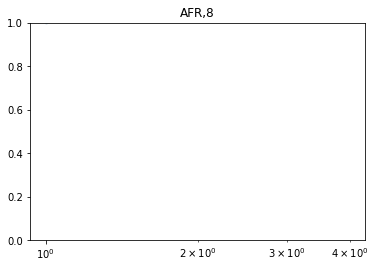

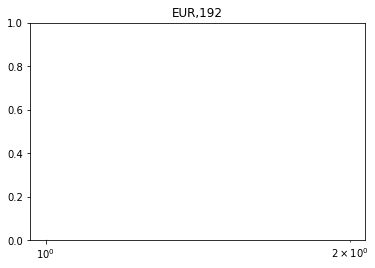

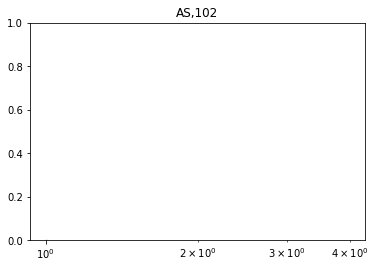

In [7]:
for pop in selected_populations:
    for focal_sample in focal_samples[pop]:
        focal_superpop = superpop_map[tables.nodes.population[focal_sample]]
        tree_iters = []
        for j in range(len(superpop_name_map)):
            tracked_samples = np.where(sample_superpop == j)[0].astype(np.int32)
            if j == 0:
                #we only need to count the samples under a node in one of the tree sets
                tree_iters.append(ts.trees(tracked_samples=tracked_samples, sample_counts=True))
            else:
                tree_iters.append(ts.trees(tracked_samples=tracked_samples))

        cousin_freq = np.zeros((ts.num_trees, 5), dtype=np.float) - 1
        n_closest_relatives = np.zeros(ts.num_trees, dtype=np.int) - 1
        tree_rgt_pos = np.zeros(ts.num_trees, dtype=np.float) - 1
        progress = tqdm.tqdm_notebook(total=ts.num_trees)
        for i, values in enumerate(zip(ts.edge_diffs(), *tree_iters)):
            (left, right), edges_out, edges_in = values[0]
            trees = values[1:]
            tree = trees[0]
            tree_rgt_pos[i] = right
            progress.update()
            #immediate parent of target sample
            focal_parent = tree.parent(focal_sample)
            n_closest_relatives[i] = n_c_r = tree.num_samples(focal_parent) - 1
            #sum up the total numbers of closest relatives, and the number that are african, etc
            for superpop in [superpop_name_map["AFR"]]: #range(5):
                flagged_relatives = trees[superpop].num_tracked_samples(focal_parent) - (superpop==focal_superpop)
                cousin_freq[i, superpop] = flagged_relatives/n_c_r
        df = pd.DataFrame({'AFR_freq':cousin_freq[:,superpop_name_map["AFR"]], 'n':n_closest_relatives})
        m = df.groupby('n')['AFR_freq'].mean()
        plt.plot(m.index, m, c="green")
        plt.scatter(n_per_pop, cousin_freq[:,superpop_name_map["AFR"]], s=3, alpha=0.1)
        ax = plt.gca()
        ax.set_xscale('log')
        ax.set_ylim(0,1)
        ax.set_title(",".join([str(x) for x in pop_descr[pop] + [focal_sample]]))
        plt.show()